In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [3]:
class Generator(nn.Module):
    def __init__(
        self,
        max_seq_len,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int,
        dropout: float = 0.1
    ):
        super(Generator, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.pos_emb = PositionalEncoding(emb_size, max_seq_len)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        
        src_emb = self.pos_emb(self.src_tok_emb(src))
        tgt_emb = self.pos_emb(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.pos_emb(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.pos_emb(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

SRC_LANGUAGE = 'en'

# Tokenizer
token_transform = get_tokenizer('spacy', language='en_core_web_sm')

# Read dataset
csv = pd.read_csv('~/datasets/en_fr/eng_-french.csv', usecols=['English words/sentences'])
train_csv, test_csv = train_test_split(csv, test_size=0.1)

print(len(train_csv))
print(len(test_csv))

# Custom Dataset class
class TranslationDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        s = self.csv.iloc[idx]['English words/sentences']
        words = s.split()
        midpoint = len(words) // 2
        return ' '.join(words[:midpoint]), ' '.join(words[midpoint:])

train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(test_csv)

# Iterate through dataset
iterator = iter(train_dataset)
print(next(iterator))
print(next(iterator))
print(next(iterator))

# Helper function to yield list of tokens
def yield_tokens(data_iter, language):
    for data_sample in data_iter:
        yield token_transform(data_sample[0])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Build vocab
vocab_transform = build_vocab_from_iterator(
    yield_tokens(train_dataset, SRC_LANGUAGE),
    min_freq=1,
    specials=special_symbols,
    special_first=True
)
vocab_transform.set_default_index(UNK_IDX)

# Function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat([torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])])

# Text transformation function
def text_transform(sentence):
    return tensor_transform(vocab_transform(token_transform(sentence)))

# Collate function for DataLoader
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample))
        tgt_batch.append(text_transform(tgt_sample))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn)

158058
17563
("I'm not", 'the problem.')
('Do you', 'like to sing?')
('She has shown', 'her room to me.')


In [13]:
MAX_SEQ_LEN = 64
SRC_VOCAB_SIZE = len(vocab_transform)
TGT_VOCAB_SIZE = len(vocab_transform)
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 256
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = 'cpu' #'cuda'
NUM_EPOCHS = 5

model = Generator(MAX_SEQ_LEN, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, 
                SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
model

Generator(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
    

In [20]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [21]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

def train_epoch(model, optimizer, loss_fn, device=DEVICE):
    print('Training')
    model.train()
    total_loss = 0

    for src, tgt in tqdm(train_dataloader):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_dataloader)

def evaluate(model, loss_fn, device=DEVICE):
    print('Validating')
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in tqdm(val_dataloader):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[:, 1:]
            loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
            total_loss += loss.item()

    return total_loss / len(val_dataloader)


In [25]:
train_loss_list, valid_loss_list = [], []
for epoch in range(1, 2):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, loss_fn, DEVICE)
    valid_loss = evaluate(model, loss_fn, DEVICE)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))

Training


  0%|          | 0/618 [00:00<?, ?it/s]

Validating


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1, Train loss: 4.406, Val loss: 3.864, Epoch time = 585.367s 



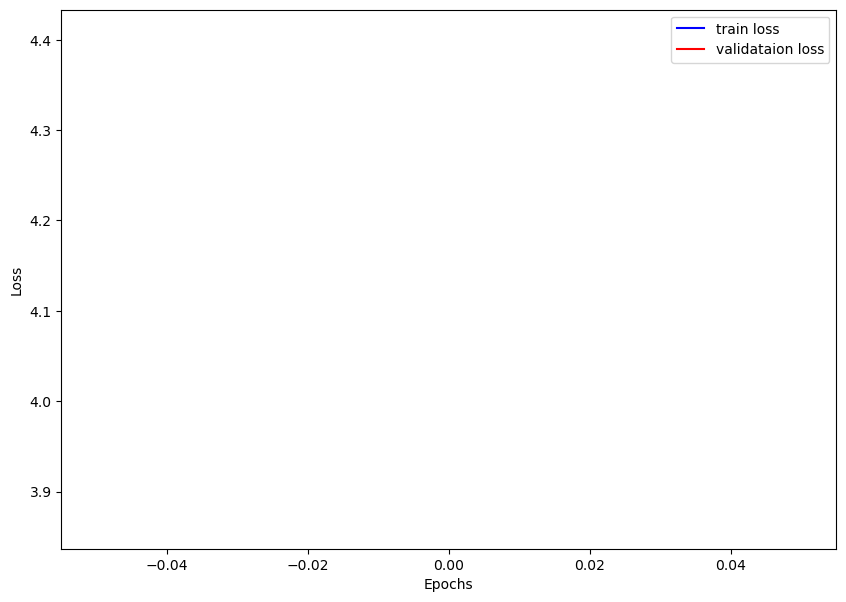

In [26]:
os.makedirs('outputs3', exist_ok=True)

def save_plots(train_loss, valid_loss):
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs3', 'loss.png'))
    plt.show()
    
save_plots(train_loss_list, valid_loss_list)
torch.save(model, 'outputs3/model.pth')
model = torch.load('outputs3/model.pth')

In [146]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

# Helper function to generate output sequence using specified decoding algorithm.
def decode(model, src, src_mask, max_len, start_symbol, beam_size=3, stochastic=False, use_beam_search=False):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    sequences = [(torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE), 0)]  # (sequence, score)

    for _ in range(max_len - 1):
        all_candidates = []
        for seq, score in sequences:
            tgt_mask = (generate_square_subsequent_mask(seq.size(1)).type(torch.bool)).to(DEVICE)
            out = model.decode(seq, memory, tgt_mask)
            prob = model.generator(out[:, -1])
            
            if use_beam_search:
                log_probs = F.log_softmax(prob, dim=1)
                topk_probs, topk_indices = log_probs.topk(beam_size)

                for i in range(beam_size):
                    next_seq = torch.cat([seq, torch.ones(1, 1).type_as(src.data).fill_(topk_indices[0][i])], dim=1)
                    next_score = score + topk_probs[0][i].item()
                    all_candidates.append((next_seq, next_score))
            else:
                _, next_word = torch.max(prob, dim=1)
                next_word = next_word.item()
                next_seq = torch.cat([seq, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
                next_score = score
                all_candidates.append((next_seq, next_score))
                if next_word == EOS_IDX:
                    return next_seq

        if use_beam_search:
            ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            sequences = ordered[:beam_size]
            if all(seq[0][-1].item() == EOS_IDX for seq, _ in sequences):
                break

    if use_beam_search:
        if stochastic:
            scores = [seq[1] for seq in sequences]
            probabilities = F.softmax(torch.tensor(scores), dim=0).numpy()
            chosen_index = np.random.choice(len(sequences), p=probabilities)
            return sequences[chosen_index][0]
        else:
            return sequences[0][0]
    else:
        return sequences[0][0]

# Translation function.
def generate(model: torch.nn.Module, src_sentence: str, use_beam_search=False, stochastic=False):
    model.eval()
    src = text_transform(src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = decode(model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX, beam_size=3, stochastic=stochastic, use_beam_search=use_beam_search).flatten()
    return src_sentence + " ".join(vocab_transform.lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

# Example usage
print(generate(model, "Take a look ", use_beam_search=True, stochastic=True))
print(generate(model, "Some ", use_beam_search=False))


Take a look  saw at are .  
Some 


In [133]:
# SRC, GT pairs from the validation set.
infer_sentences = [
    ["Take a"],
    ["I'm not scared"],
    ["You'd better make"],
    ["The clock has"],
    ["Take any two cards"]
]

for sentence in infer_sentences:
    print(f"SRC: {sentence[0]}")
    print(f"PRED: {generate_beam(model, sentence[0], True)}\n")

SRC: Take a
PRED: Take a here of whole . 

SRC: I'm not scared
PRED: I'm not scared of my years . 

SRC: You'd better make
PRED: You'd better make <unk> , do n't you problem  .  .

SRC: The clock has
PRED: The clock has a here of keep .  .  .

SRC: Take any two cards
PRED: Take any two cards 'd the <unk> of <unk> .   . 



In [147]:
generate_beam(model, "Move your", True)

'Move your See , makes .  . '